10 epoch loss 0.005976542
20 epoch loss 0.004743115
30 epoch loss 0.0045258966
40 epoch loss 0.0039596804
50 epoch loss 0.0032732873
60 epoch loss 0.0021769053
70 epoch loss 0.00021771064
80 epoch loss 0.00012539783
90 epoch loss 0.00015589915
Green = Real
Red = Predicted


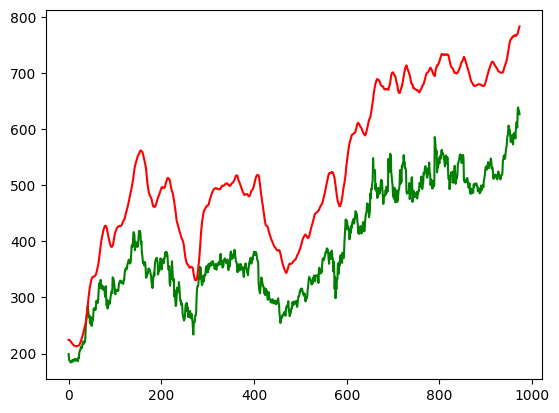

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

df = pd.read_csv("netflix.csv")
closed_prices = df["Close"]

seq_len = 15

mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()

X = []
y = []

for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i : i + seq_len])
    y.append(scaled_price[i + seq_len])

X = np.array(X)[... , None]
y = np.array(y)[... , None]
    
train_x = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float()
test_x = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float()

class Model(nn.Module):
    def __init__(self , input_size , hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size , hidden_size , batch_first = True)
        self.fc = nn.Linear(hidden_size , 1)
    def forward(self , x):
        output , (hidden , cell) = self.lstm(x)
        return self.fc(hidden[-1 , :])
model = Model(1 , 64)

optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)
loss_fn = nn.MSELoss()

num_epochs = 100

for epoch in range(num_epochs):
    output = model(train_x)
    loss = loss_fn(output , train_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 and epoch != 0:
        print(epoch , "epoch loss" , loss.detach().numpy())

model.eval()
with torch.no_grad():
    output = model(test_x)

pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())
print('Green = Real')
print('Red = Predicted')
plt.plot(real.squeeze() , color = "green" , label = "real")
plt.plot(pred.squeeze() , color = "red" , label = "predicted")
plt.show()